# Euclid30K 数据集可视化

## 简介

Euclid30K 是一个包含约30,000个平面和立体几何问题的多模态数据集。该数据集旨在通过欧几里得几何问题解决作为代理任务，提升多模态大语言模型（MLLMs）的空间智能能力。

本笔记本将展示数据集中的图像数据和对应的中英文文本问题。

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import json
from PIL import Image
import io
import base64

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置数据集路径
DATA_PATH = "/Users/jia/datasets/Euclid30K"

print(f"数据集路径: {DATA_PATH}")
print(f"数据集目录是否存在: {os.path.exists(DATA_PATH)}")

数据集路径: /Users/jia/datasets/Euclid30K
数据集目录是否存在: True


In [2]:
# 检查数据集文件
data_files = list(Path(DATA_PATH).glob("*.parquet"))
print("数据集文件列表:")
for file in data_files:
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"  {file.name}: {size_mb:.2f} MB")

数据集文件列表:
  Euclid30K_train.parquet: 775.77 MB
  Euclid30K_val.parquet: 14.36 MB


In [3]:
# 加载验证集数据（较小，用于演示）
val_file = os.path.join(DATA_PATH, "Euclid30K_val.parquet")
print(f"正在加载验证集数据: {val_file}")

try:
    val_df = pd.read_parquet(val_file)
    print(f"验证集数据加载成功，形状: {val_df.shape}")
    print(f"列名: {list(val_df.columns)}")
except Exception as e:
    print(f"加载验证集数据时出错: {e}")
    val_df = None

正在加载验证集数据: /Users/jia/datasets/Euclid30K/Euclid30K_val.parquet
验证集数据加载成功，形状: (500, 3)
列名: ['problem', 'images', 'answer']


In [4]:
# 查看样本数据
if val_df is not None:
    print("=== 验证集样本 ===")
    print(val_df.head())
    
    # 查看第一个样本的图像数据格式
    print(f"\n第一个样本的图像数据类型: {type(val_df.iloc[0]['images'])}")
    print(f"第一个样本的图像数据预览: {str(val_df.iloc[0]['images'])[:200]}...")

=== 验证集样本 ===
                                             problem  \
0  <image>As shown in the figure, in the right tr...   
1  <image>Two squares are placed with one right-a...   
2  As shown in the figure is the net of a cube. I...   
3  <image> As shown in Figure 2 - 15 - 20, in the...   
4  $如图①，在\triangle ABC中，AB\perp BC，且AB=2BC，将\tria...   

                                              images                 answer  
0  [{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...                      6  
1  [{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...                     16  
2  [{'bytes': b'\xff\xd8\xff\xdb\x00\x84\x00\x08\...                      3  
3  [{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...        $\frac{a^3}{2}$  
4  [{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\...  $-\frac{\sqrt{3}}{3}$  

第一个样本的图像数据类型: <class 'numpy.ndarray'>
第一个样本的图像数据预览: [{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x

In [5]:
# 分析图像数据格式
if val_df is not None:
    # 检查图像数据的结构
    sample_image_data = val_df.iloc[0]['images']
    print(f"图像数据类型: {type(sample_image_data)}")
    
    if isinstance(sample_image_data, list):
        print(f"列表长度: {len(sample_image_data)}")
        if len(sample_image_data) > 0:
            print(f"列表第一项类型: {type(sample_image_data[0])}")
            if isinstance(sample_image_data[0], dict):
                print(f"字典键: {sample_image_data[0].keys()}")
                if 'bytes' in sample_image_data[0]:
                    print(f"bytes键值类型: {type(sample_image_data[0]['bytes'])}")
                    print(f"bytes长度: {len(sample_image_data[0]['bytes'])}")

图像数据类型: <class 'numpy.ndarray'>


样本问题: <image>As shown in the figure, in the right triangle ABC, ∠C=90°, AB=5, AC=4. Semicircles are drawn ...
样本答案: 6
图像加载成功，尺寸: (175, 120), 模式: RGB


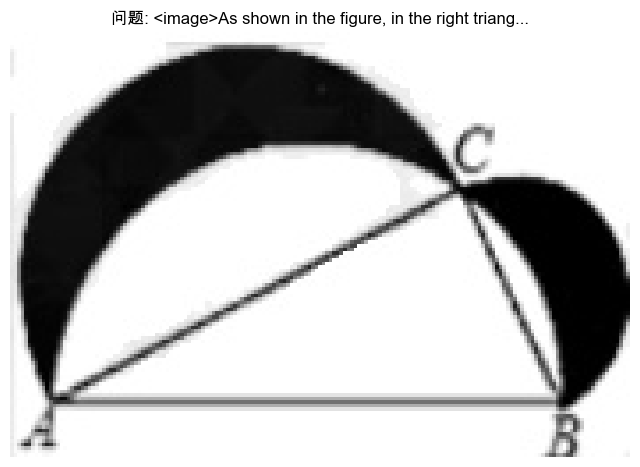

In [14]:
# 定义函数来从字节数据加载图像
def load_image_from_bytes(image_bytes_data):
    """
    从字节数据加载图像

    Args:
        image_bytes_data: 图像的字节数据，可能是字典格式或直接的字节串

    Returns:
        PIL图像对象
    """
    try:
        # 如果是numpy数组，先转换为对象
        if isinstance(image_bytes_data, np.ndarray):
            image_bytes_data = image_bytes_data.item()
        
        # 如果是列表格式，取第一个元素
        if isinstance(image_bytes_data, list) and len(image_bytes_data) > 0:
            image_bytes_data = image_bytes_data[0]
        
        # 如果是字典格式，提取bytes字段
        if isinstance(image_bytes_data, dict):
            image_bytes = image_bytes_data.get('bytes')
        else:
            image_bytes = image_bytes_data
        
        # 确保是bytes类型
        if isinstance(image_bytes, str):
            # 如果是字符串，可能是base64编码的
            try:
                image_bytes = base64.b64decode(image_bytes)
            except Exception:
                print(f"无法解析图像数据字符串")
                return None
        
        # 将字节数据转换为图像
        image_stream = io.BytesIO(image_bytes)
        image = Image.open(image_stream)
        
        return image
    except Exception as e:
        print(f"加载图像时出错: {e}")
        return None

# 尝试加载并显示第一个样本的图像
if val_df is not None:
    sample = val_df.iloc[0]
    print(f"样本问题: {sample['problem'][:100]}...")
    print(f"样本答案: {sample['answer']}")
    
    # 尝试加载图像
    image = load_image_from_bytes(sample['images'])
    
    if image is not None:
        print(f"图像加载成功，尺寸: {image.size}, 模式: {image.mode}")
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"问题: {sample['problem'][:50]}...", fontsize=12)
        plt.show()
    else:
        print("图像加载失败")
        
        # 打印更详细的错误信息
        sample_image_data = sample['images']
        print(f"图像数据类型: {type(sample_image_data)}")
        print(f"图像数据预览: {str(sample_image_data)[:300]}...")


样本 1:
  问题: <image>As shown in the figure, in the right triangle ABC, ∠C=90°, AB=5, AC=4. Se...
  答案: 6
  图像加载成功，尺寸: (175, 120), 模式: RGB


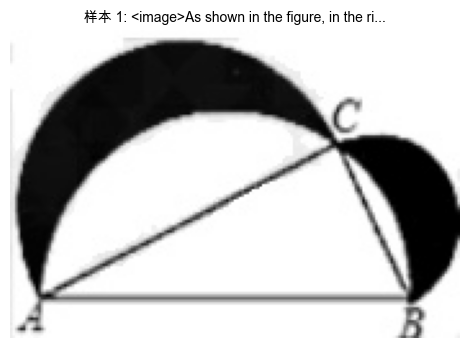


样本 2:
  问题: <image>Two squares are placed with one right-angle vertex of a right-angled tria...
  答案: 16
  图像加载成功，尺寸: (165, 98), 模式: RGB


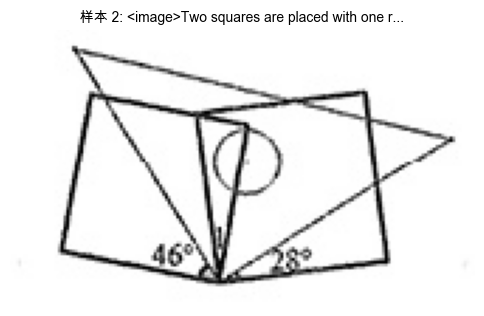


样本 3:
  问题: As shown in the figure is the net of a cube. If it is folded into a cube, the nu...
  答案: 3
  图像加载成功，尺寸: (234, 174), 模式: RGB


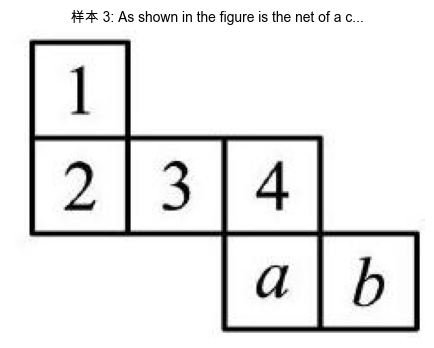

In [15]:
# 使用改进版函数加载图像
if val_df is not None:
    # 尝试加载前几个样本的图像
    for i in range(min(3, len(val_df))):
        sample = val_df.iloc[i]
        print(f"\n样本 {i+1}:")
        print(f"  问题: {sample['problem'][:80]}...")
        print(f"  答案: {sample['answer']}")
        
        image = load_image_from_bytes(sample['images'])
        
        if image is not None:
            print(f"  图像加载成功，尺寸: {image.size}, 模式: {image.mode}")
            plt.figure(figsize=(6, 4))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"样本 {i+1}: {sample['problem'][:40]}...", fontsize=10)
            plt.show()
        else:
            print(f"  图像加载失败")

问题语言分布:
language
English    468
Chinese     32
Name: count, dtype: int64


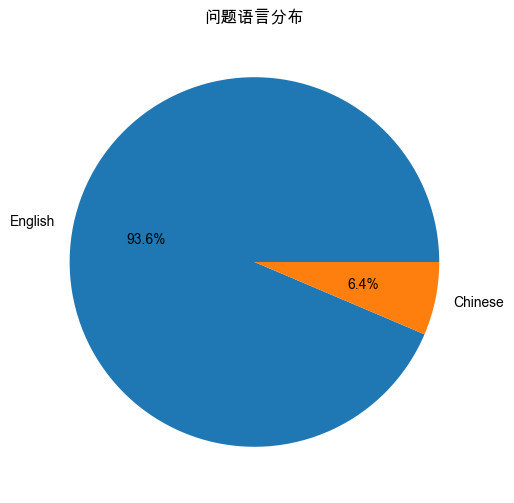

In [10]:
# 统计分析 - 问题语言类型
if val_df is not None:
    # 检测中文和英文问题
    def detect_language(text):
        # 简单的中文检测方法：检查是否存在中文字符
        for char in text:
            if '\u4e00' <= char <= '\u9fff':
                return 'Chinese'
        return 'English'
    
    # 应用语言检测
    val_df['language'] = val_df['problem'].apply(detect_language)
    
    # 统计语言分布
    language_counts = val_df['language'].value_counts()
    print("问题语言分布:")
    print(language_counts)
    
    # 绘制语言分布饼图
    plt.figure(figsize=(8, 6))
    plt.pie(language_counts.values, labels=language_counts.index, autopct='%1.1f%%')
    plt.title('问题语言分布')
    plt.show()

In [11]:
# 按语言显示样本
if val_df is not None:
    # 显示中文样本
    chinese_samples = val_df[val_df['language'] == 'Chinese']
    print(f"中文问题样本 (共{len(chinese_samples)}个):")
    for i in range(min(3, len(chinese_samples))):
        sample = chinese_samples.iloc[i]
        print(f"  {i+1}. {sample['problem'][:100]}... -> 答案: {sample['answer']}")
    
    print()
    
    # 显示英文样本
    english_samples = val_df[val_df['language'] == 'English']
    print(f"英文问题样本 (共{len(english_samples)}个):")
    for i in range(min(3, len(english_samples))):
        sample = english_samples.iloc[i]
        print(f"  {i+1}. {sample['problem'][:100]}... -> 答案: {sample['answer']}")

中文问题样本 (共32个):
  1. $如图①，在\triangle ABC中，AB\perp BC，且AB=2BC，将\triangle ABC沿中位线EF折起，使得AE\perp BE，连接AB，AC，M为AC的中点，连接ME，MF(... -> 答案: $-\frac{\sqrt{3}}{3}$
  2. $如图所示，已知多面体ABCD-A_{1}B_{1}C_{1}D_{1}为正方体.$<image>
$(2)若E，F分别为AB，AD的中点，求A_{1}C_{1}与EF所成角的大小.$... -> 答案: $90^\circ$
  3. $如图，在三棱柱ABC-A_1B_1C_1中，BB_1\perp 平面ABC，AB\perp BC，AA_1=AB=BC=2.$

<image>
$点M在线段B_1C上，且\frac{B_1M}{B... -> 答案: $\frac{2}{3}$

英文问题样本 (共468个):
  1. <image>As shown in the figure, in the right triangle ABC, ∠C=90°, AB=5, AC=4. Semicircles are drawn ... -> 答案: 6
  2. <image>Two squares are placed with one right-angle vertex of a right-angled triangle overlapping, as... -> 答案: 16
  3. As shown in the figure is the net of a cube. If it is folded into a cube, the number opposite to $b$... -> 答案: 3


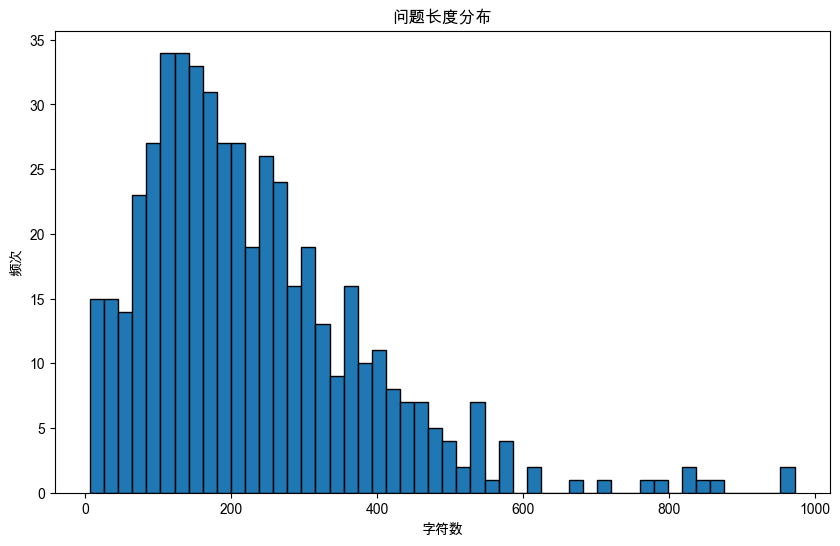

问题长度统计:
平均长度: 230.79
最短长度: 7
最长长度: 972


In [12]:
# 问题长度分析
if val_df is not None:
    # 计算问题长度
    val_df['problem_length'] = val_df['problem'].apply(len)
    
    # 绘制问题长度分布
    plt.figure(figsize=(10, 6))
    plt.hist(val_df['problem_length'], bins=50, edgecolor='black')
    plt.title('问题长度分布')
    plt.xlabel('字符数')
    plt.ylabel('频次')
    plt.show()
    
    print(f"问题长度统计:")
    print(f"平均长度: {val_df['problem_length'].mean():.2f}")
    print(f"最短长度: {val_df['problem_length'].min()}")
    print(f"最长长度: {val_df['problem_length'].max()}")

In [13]:
# 总结
if val_df is not None:
    print("=== Euclid30K 数据集可视化总结 ===")
    print(f"验证集大小: {val_df.shape}")
    print(f"问题类型数量: {val_df['problem'].nunique()}")
    print(f"答案类型数量: {val_df['answer'].nunique()}")
    print(f"中文问题数量: {(val_df['language'] == 'Chinese').sum()}")
    print(f"英文问题数量: {(val_df['language'] == 'English').sum()}")
    
    print(f"\n数据集特点:")
    print("1. 多语言支持：包含中文和英文几何问题")
    print("2. 多模态数据：包含图像和文本")
    print("3. 几何问题类型丰富：涵盖平面几何和立体几何")
    print("4. 答案格式多样：包括数值、表达式、文字等多种形式")

=== Euclid30K 数据集可视化总结 ===
验证集大小: (500, 5)
问题类型数量: 497
答案类型数量: 332
中文问题数量: 32
英文问题数量: 468

数据集特点:
1. 多语言支持：包含中文和英文几何问题
2. 多模态数据：包含图像和文本
3. 几何问题类型丰富：涵盖平面几何和立体几何
4. 答案格式多样：包括数值、表达式、文字等多种形式
